# Generate features (acoustic, phonetic, and lexical) for stimuli
## 0. Some basic functions
### 0.1. Test multicollinearity

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(X_i,corr_labels):
    
    # Ensure the input is a NumPy array
    if not isinstance(X_i, np.ndarray):
        raise ValueError("Input X_i must be a NumPy array")

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = corr_labels
    vif_data["VIF"] = [variance_inflation_factor(X_i, i) for i in range(X_i.shape[1])]

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(X_i, rowvar=False)  # Compute correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=corr_labels, yticklabels=corr_labels,annot_kws={"size": 20})
    plt.title("Feature Correlation Matrix")
    plt.show()

    return vif_data

## 1. Phonemic feature matrix
### 1.1. Get MFA dictionary

In [56]:
def read_syllable_dict(file_path):
    """
    Reads a file and returns a dictionary with words as keys and phoneme lists as values.
    Ignores the numeric middle section between tabs, extracting only word and phonemes.
    
    Args:
        file_path (str): Path to the file
    
    Returns:
        dict: {word: [phonemes]}
    """
    syllable_dict = {}
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Remove leading/trailing whitespace and split by tabs
            parts = line.strip().split('\t')

            # Extract word (first part) and phonemes (third part)
            word = parts[0].replace("'", "")  # Remove single quotes if present
            if len(parts) == 6:
                phonemes_str = parts[5]  # Third part is the phonemes
            elif len(parts) == 2:
                phonemes_str = parts[1]  # Third part is the phonemes
            else:
                continue

            # Split phonemes by spaces into a list
            phonemes = phonemes_str.split()
            if not phonemes:  # If no phonemes found, skip the line
                print(f"No phonemes found in line: {line.strip()}")
                continue
                
            # Store in dictionary
            syllable_dict[word] = phonemes
    
    return syllable_dict

In [57]:
file_path = "english_us_lr.dict"
# Create the filename-to-phoneme dictionary
dict = read_syllable_dict(file_path)
for word, syllables in list(dict.items())[:10]:
    print(f"{word}: {syllables}")

d: ['D']
ll: ['L']
re: ['R', 'EY1']
s: ['EH1', 'S']
ve: ['V', 'IY1', 'IY1']
[bracketed]: ['spn']
<cutoff>: ['spn']
a: ['EY1']
as: ['EH1', 'Z']
abody: ['EY1', 'B', 'AA2', 'D', 'IY0']


### 1.2. Get the stimuli phonemic dictionary for the Lexical Delay Experiment

In [58]:
import os

def get_wav_files(directory):
    wav_files_names = {}
    wav_files = []
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return wav_files
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith('.wav'):  # Case-insensitive check for .wav files
            # Add to dictionary (key is filename, value can be None or customized)
            wav_files_names[filename[:-4]] = None
    return wav_files_names

In [59]:
directory = r"C:\Users\bl314\Box\CoganLab\task_stimuli\LexicalDecRepDelay"
syllables = get_wav_files(directory)
for syllable in syllables.keys():
    syllables[syllable] = dict.get(syllable)
    print(f"{syllable}: {syllables[syllable]}")

bacon: ['B', 'EY1', 'K', 'AH0', 'N']
bagel: ['B', 'EY1', 'G', 'AH0', 'L']
banel: ['B', 'AE1', 'N', 'AH0', 'L']
banic: ['B', 'AE1', 'N', 'IH0', 'K']
baron: ['B', 'AE1', 'R', 'AH0', 'N']
basin: ['B', 'EY1', 'S', 'AH0', 'N']
belet: ['B', 'EH1', 'L', 'EH0', 'T']
berin: ['B', 'AE1', 'R', 'IH0', 'N']
beris: ['B', 'AE1', 'R', 'IH0', 'S']
bison: ['B', 'AY1', 'S', 'AH0', 'N']
bonus: ['B', 'OW1', 'N', 'AH0', 'S']
boreb: ['B', 'AO1', 'R', 'AH0', 'B']
boril: ['B', 'AO1', 'R', 'AH0', 'L']
cabin: ['K', 'AE1', 'B', 'AH0', 'N']
camel: ['K', 'AE1', 'M', 'AH0', 'L']
caris: ['K', 'AE1', 'R', 'AH0', 'S']
casef: ['K', 'AA1', 'S', 'IH0', 'F']
cazel: ['K', 'AA1', 'Z', 'AH0', 'L']
civic: ['S', 'IH1', 'V', 'IH0', 'K']
civil: ['S', 'IH1', 'V', 'AH0', 'L']
cobin: ['K', 'AA1', 'B', 'IH0', 'N']
colon: ['K', 'OW1', 'L', 'AH0', 'N']
comet: ['K', 'AA1', 'M', 'AH0', 'T']
comic: ['K', 'AA1', 'M', 'IH0', 'K']
coral: ['K', 'AO1', 'R', 'AH0', 'L']
davel: ['D', 'EY1', 'V', 'AH0', 'L']
delin: ['D', 'EH1', 'L', 'IH0', 'N']
d

### 1.3. One-hot encoding for each unique phoneme

In [60]:
# Get unique phoneme vector
all_phonemes = set()
for phonemes in syllables.values():
    all_phonemes.update(phonemes)
all_phonemes = sorted(list(all_phonemes))  # Sort for consistent ordering
phoneme_to_index = {phoneme: idx for idx, phoneme in enumerate(all_phonemes)}
vector_length = len(all_phonemes)

# Create one-hot encoding for each word
phoneme_one_hot_dict = {}
for word, phonemes in syllables.items():
    # Initialize vector with zeros
    vector = [0] * vector_length
    # Set 1 for each phoneme present in the word
    for phoneme in phonemes:
        vector[phoneme_to_index[phoneme]] = 1
    phoneme_one_hot_dict[word] = vector

C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


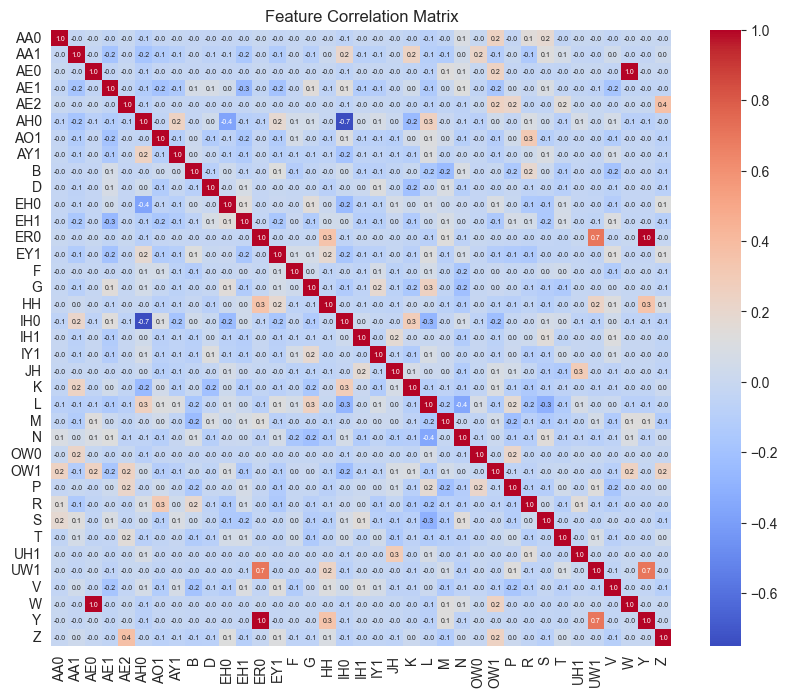

fatal: ['F', 'EY1', 'T', 'AH0', 'L'] contains T, L and AH0
fetal: ['F', 'IY1', 'T', 'AH0', 'L'] contains T, L and AH0
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains ER0
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains Y
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains UW1
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains both HH and M
latin: ['L', 'AE1', 'T', 'AH0', 'N'] contains T, L and AH0
metal: ['M', 'EH1', 'T', 'AH0', 'L'] contains T, L and AH0
natal: ['N', 'EY1', 'T', 'AH0', 'L'] contains T, L and AH0
petal: ['P', 'EH1', 'T', 'AH0', 'L'] contains T, L and AH0
roman: ['R', 'OW1', 'M', 'AH0', 'N'] contains OW1, M and N
tidal: ['T', 'AY1', 'D', 'AH0', 'L'] contains T, L and AH0
torel: ['T', 'AO1', 'R', 'AH0', 'L'] contains T, L and AH0
tulip: ['T', 'UW1', 'L', 'AH0', 'P'] contains UW1
tulip: ['T', 'UW1', 'L', 'AH0', 'P'] contains T, L and AH0
vital: ['V', 'AY1', 'T', 'AH0', 'L'] contains T, L and AH0
woman: ['W', 'OW1', 'M', 'AE0', 'N'] contains AE0
woman: ['W', 'OW1', 'M', 'AE0', 'N'] co

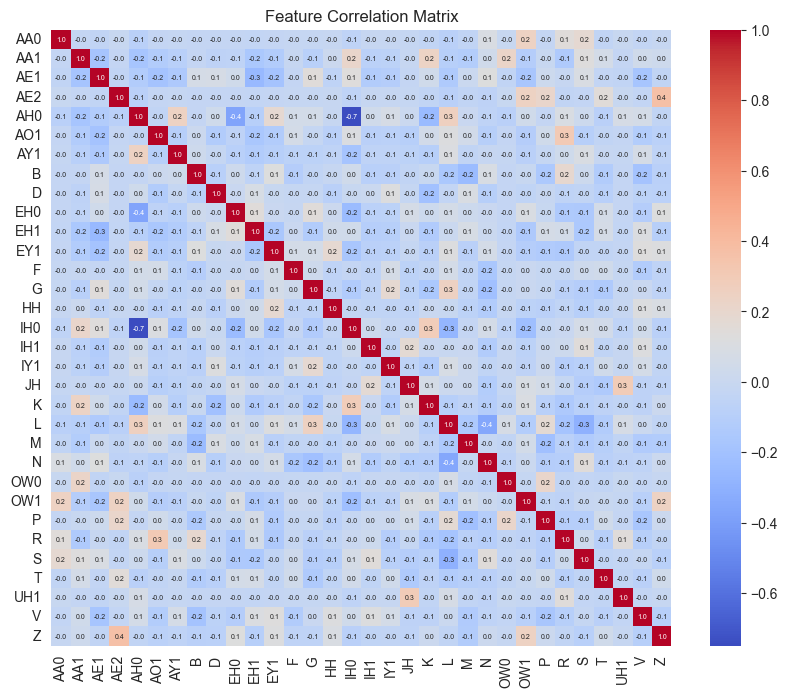

,Feature,VIF
0,AA0,1.797883
1,AA1,12.151341
2,AE1,24.295500
3,AE2,2.123477
4,AH0,63.877386
5,AO1,12.804207
6,AY1,7.487775
7,B,2.551980
8,D,2.002115
9,EH0,13.851950


In [61]:
# Check the multicolinearity and reduce the feature dimensions
check_multicollinearity(np.array(list(phoneme_one_hot_dict.values())),all_phonemes)
# Print the words tha contain AE0, W, ER0, and Y
for syllable, value in syllables.items():
    if value and "AE0" in value:
        print(f"{syllable}: {value} contains AE0")
    if value and "W" in value:
        print(f"{syllable}: {value} contains W")
    if value and "ER0" in value:
        print(f"{syllable}: {value} contains ER0")
    if value and "Y" in value:
        print(f"{syllable}: {value} contains Y")
    if value and "UW1" in value:
        print(f"{syllable}: {value} contains UW1")
    if value and "HH" in value and "M" in value:
        print(f"{syllable}: {value} contains both HH and M")
    if value and "T" in value and "L" in value and "AH0" in value:
        print(f"{syllable}: {value} contains T, L and AH0")
    if value and "OW1" in value and "M" in value and "N" in value:
        print(f"{syllable}: {value} contains OW1, M and N")
# I think it is safe to reduce ER0, Y, UW1, AE0, and W
# Then: humor - HH and M, tulip - 'T', 'L', 'AH0', 'P', women - 'OW1', 'M', 'N'

# reduce the dimensions:
indices_to_remove=[all_phonemes.index("ER0"),all_phonemes.index("Y"),all_phonemes.index("UW1"),all_phonemes.index("AE0"),all_phonemes.index("W")]
phoneme_one_hot_dict_filt = {key: vec for key, vec in phoneme_one_hot_dict.items()}
for i, (key, vec) in enumerate(phoneme_one_hot_dict.items()):
    # Create a copy of the vector with specified indices removed
    filtered_vec = np.delete(vec, indices_to_remove)
    phoneme_one_hot_dict_filt[key] = filtered_vec
all_phonemes_filt = []
all_phonemes_filt = [p for i, p in enumerate(all_phonemes) if i not in indices_to_remove]

# Check the multicolinearity again
check_multicollinearity(np.array(list(phoneme_one_hot_dict_filt.values())),all_phonemes_filt)

In [62]:
# save the phoneme_one_hot_dicphoneme_one_hot_dictt
import pickle
phoneme_one_hot_dict_path = "phoneme_one_hot_dict.pickle"
with open(phoneme_one_hot_dict_path, 'wb') as handle:
    pickle.dump(phoneme_one_hot_dict_filt, handle)

In [63]:
# # Read the saved one hot dict. Just for demonstration
# import pandas as pd
# d= pd.read_pickle("phoneme_one_hot_dict.pickle")

## 2. Acoustic feature (Power envelope at five frequency bins)
### 2.1. Read normolized binned envelope 
(The matrix was generated by `get_stims_envelope.m`)

In [64]:
envelope_feature_dict = {}

with open("envelope_power_bins.txt", "r") as file:
    for line in file:
        parts = line.strip().split("\t")
        key = parts[0]
        values = list(map(float, parts[1:]))  # Convert remaining columns to float
        envelope_feature_dict[key] = values

# Print a sample of the dictionary
for key, values in list(envelope_feature_dict.items())[:5]:  # Show first 5 entries
    print(key, ":", values)

bacon : [0.74574, 0.637592, 0.459571, 0.799834, 0.249223]
bagel : [0.790974, 0.632659, 0.508791, 0.898081, 0.243668]
banel : [0.584685, 0.661659, 0.721426, 0.813079, 0.46464]
banic : [0.595901, 0.744453, 0.693261, 0.731105, 0.465257]
baron : [0.744477, 0.96389, 0.91162, 0.67948, 0.462083]


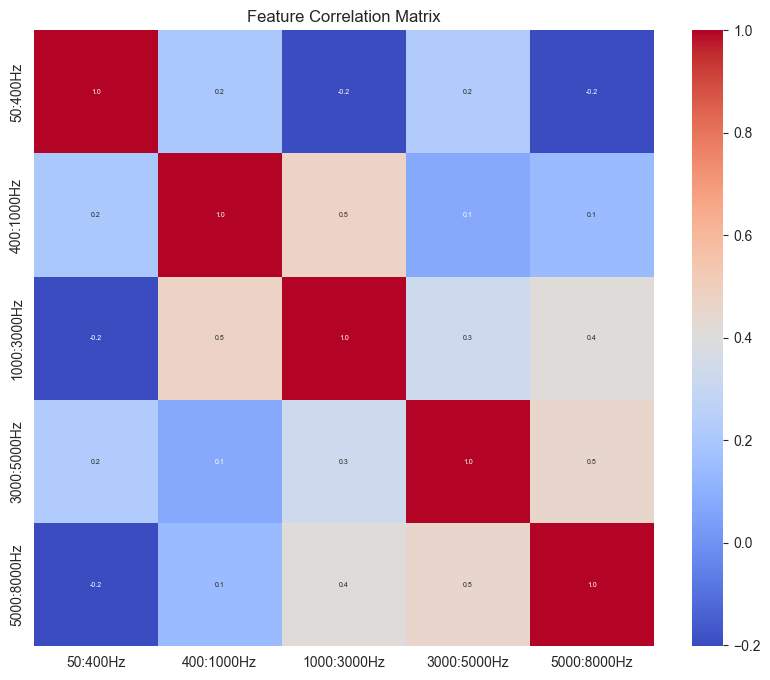

,Feature,VIF
0,50:400Hz,14.525940
1,400:1000Hz,14.840691
2,1000:3000Hz,13.859316
3,3000:5000Hz,17.639159
4,5000:8000Hz,6.616839


In [65]:
# # Check the multicolinearity and reduce the feature dimensions
check_multicollinearity(np.array(list(envelope_feature_dict.values())),
                        ["50:400Hz","400:1000Hz","1000:3000Hz","3000:5000Hz","5000:8000Hz"])

In [66]:
# Save dictionary
import pickle
envelope_feature_dict_path = "envelope_feature_dict.pickle"
with open(envelope_feature_dict_path, 'wb') as handle:
    pickle.dump(envelope_feature_dict, handle)